In [ ]:
!pip install openai

!pip install transformers
!pip install tokenizers





Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached openai-0.27.1.tar.gz (57 kB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from google.colab import drive
import random
#gpt2
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel, GPT2Config
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

#pytorch
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Your code here # read data
trump_tweets=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/realdonaldtrump.csv")
trump_tweets.head()

,id,link,content,date,retweets,favorites,mentions,hashtags
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [ ]:
#tweets_fil =trump_tweets[trump_tweets['isRetweet']=='f']
#del trump_tweets

tweets = trump_tweets['content'].copy()
#tweets =tweets[:30000]
tweets.head()
print(tweets)

0        Be sure to tune in and watch Donald Trump on L...
1        Donald Trump will be appearing on The View tom...
2        Donald Trump reads Top Ten Financial Tips on L...
3        New Blog Post: Celebrity Apprentice Finale and...
4        "My persona will never be that of a wallflower...
                               ...                        
43347    Joe Biden was a TOTAL FAILURE in Government. H...
43348    Will be interviewed on @ seanhannity tonight a...
43349                           pic.twitter.com/3lm1spbU8X
43350                           pic.twitter.com/vpCE5MadUz
43351                           pic.twitter.com/VLlc0BHW41
Name: content, Length: 43352, dtype: object


In [ ]:

# Load the Trump tweet corpus
#trump_tweets = pd.read_csv('trump_tweets.csv', encoding='utf-8')

# Preprocess the tweets by removing URLs, mentions, and hashtags
def preprocess_tweet_text(tweet):
    # Remove URLs
    tweet = re.sub(r"http\S+", "", tweet)
    # Remove mentions
    tweet = re.sub(r"@\S+", "", tweet)
    # Remove hashtags
    tweet = re.sub(r"#\S+", "", tweet)
    # Remove newline characters
    tweet = tweet.replace('\n', ' ')
    # Remove extra spaces
    tweet = re.sub(r"\s+", ' ', tweet)
    return tweet.strip()


#Section 1.2 Cleaning the data:
# text cleaning

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def rm_punct2(text):
    return re.sub(r'["\-]', ' ', text)
    
def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

# def space_bt_punct(text):
#     pattern = r'([.,!?-])'
#     s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
#     s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces    
#     return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def make_lower(text):
  return text.lower()

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):    
    no_link = rm_link(text)
    no_punct = rm_punct2(no_link)
    """
    no_html = rm_html(no_link)
    no_extra= preprocess_tweet_text(no_html)
    #space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(no_extra)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    lower = make_lower(no_emoji)
    spell_corrected = spell_correction(lower)
    """
    return no_punct

  
print(tweets)
tweets = tweets.apply(clean_pipeline)
tweets=tweets.replace('', np.nan).dropna()
tweets.head()
print(tweets)
tweets.size

0        Be sure to tune in and watch Donald Trump on L...
1        Donald Trump will be appearing on The View tom...
2        Donald Trump reads Top Ten Financial Tips on L...
3        New Blog Post: Celebrity Apprentice Finale and...
4        "My persona will never be that of a wallflower...
                               ...                        
43347    Joe Biden was a TOTAL FAILURE in Government. H...
43348    Will be interviewed on @ seanhannity tonight a...
43349                           pic.twitter.com/3lm1spbU8X
43350                           pic.twitter.com/vpCE5MadUz
43351                           pic.twitter.com/VLlc0BHW41
Name: content, Length: 43352, dtype: object
0        Be sure to tune in and watch Donald Trump on L...
1        Donald Trump will be appearing on The View tom...
2        Donald Trump reads Top Ten Financial Tips on L...
3        New Blog Post: Celebrity Apprentice Finale and...
4         My persona will never be that of a wallflower...
            

43351

In [ ]:

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|sos|>', 
                                          eos_token='<|eos|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[36674, 8255]

Here I added three new tokens in the pre-trained GPT2 tokenizer: \ <|sos|> : start of sentence \ <|eos|> : end of sentence \ <|pad|> : padding token



In [ ]:
max_tweet = min(max([len(tokenizer.encode(tweet)) for tweet in tweets]),100)

print(f'The longest tweet is {max_tweet} tokens long.')

The longest tweet is 100 tokens long.


Next we create a custom dataloader for our tweets using torch Dataset. \ Each entry in the dataset will be two tensors, one which is the encoding for the string and one which is the attention mask



In [ ]:
batch_size = 32

class TweetDataset(Dataset):
    def __init__(self,tweets,tokenizer,gpt2_type="gpt2",max_length=max_tweet):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attention_masks = []
        
        for tweet in tweets:
            encoding_dict = tokenizer('<|sos|>'+ tweet +'<|eos|>',truncation=True,
                                     max_length=max_length,
                                     padding='max_length')
            
            self.input_ids.append(torch.tensor(encoding_dict['input_ids']))
            self.attention_masks.append(torch.tensor(encoding_dict['attention_mask']))
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self,idx):
        return self.input_ids[idx], self.attention_masks[idx]

In [ ]:
#90% training 10% validation

dataset = TweetDataset(tweets,tokenizer,max_length=max_tweet)
train_size = int(0.90 * len(dataset))
val_size = len(dataset)-train_size

train,val = random_split(dataset,[train_size,val_size])
print(f'Number of train samples = {train_size} and Number of validation samples = {val_size}')

Number of train samples = 39015 and Number of validation samples = 4336


In [ ]:
import torch
import torch.nn as nn

configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
# Define dropout probability
dropout_prob = 0.081

# Add dropout to each layer of the model
for layer in model.transformer.h:
    layer.dropout = nn.Dropout(dropout_prob)
    
model.resize_token_embeddings(len(tokenizer))
model.cuda()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs =10
warmup_steps = 1e2
sample_every = 100

In [ ]:
train_dataloader = DataLoader(train,sampler = RandomSampler(train),
                             batch_size = batch_size)

val_dataloader = DataLoader(val,sampler = SequentialSampler(val),
                           batch_size = batch_size)

In [ ]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.1)



In [ ]:

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
         

In [ ]:

import gc
gc.collect()
torch.cuda.empty_cache()


In [ ]:
!nvidia-smi


Fri Mar 10 19:56:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |   5391MiB / 15360MiB |     40%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import time
import datetime
import os
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):
    
    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        
        
        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1,
                                    pad_token_id=tokenizer.eos_token_id
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 10
Batch 100 of 1220. Loss:1.8095057010650635. Time:0:01:24
Example output:  bipartisan, economic, and security policy alike. President Trump is the best of the best.

Batch 200 of 1220. Loss:1.4523214101791382. Time:0:02:49
Example output:  increasing.
Batch 300 of 1220. Loss:1.5672852993011475. Time:0:04:15
Example output: day the
Batch 400 of 1220. Loss:1.4591038227081299. Time:0:05:40
Example output:  HangWe are working hard to reach an agreement on the deal: Great! (AP) @ FoxNews @washingtonpost/: # TRUMPYOUR_PERMIT_FLOTUS was a success!!!
Batch 500 of 1220. Loss:1.5337756872177124. Time:0:07:05
Example output:  foods for children
Batch 600 of 1220. Loss:1.398107647895813. Time:0:08:29
Example output:  trail, to celebrate the 40th anniversary of the landmark building of the historic Columbus, Ohio, Ship Building. The parade was held at the Newseum.    
Batch 700 of 1220. Loss:1.6281474828720093. Time:0:09:54
Example output: intendJtweet: @ NBCNews, I don't wan

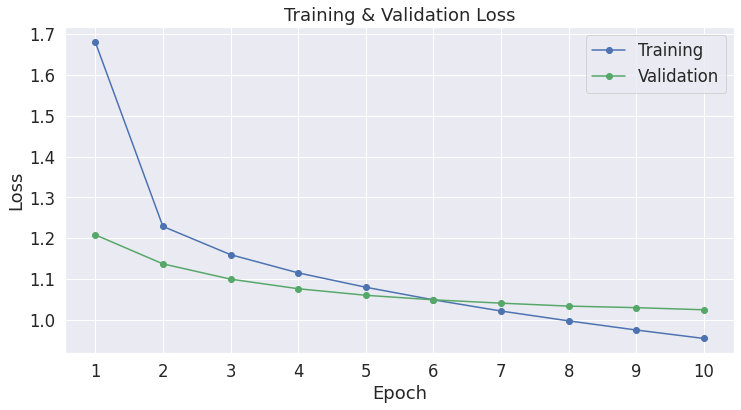

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('precision', 10)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
xt = [i for i in range(1,epochs+1)]
plt.xticks(xt)

plt.show()

In [ ]:
import os
out_dir = '/content/drive/MyDrive/Colab Notebooks/'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained('./')
tokenizer.save_pretrained('./')
model_to_save.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)



('/content/drive/MyDrive/Colab Notebooks/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/added_tokens.json')

In [ ]:

model.eval()

prompt = "<|sos|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=5
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Why is @ BarackObama allowing @ MittRomney to fundraise after raising more than $5 million for charity & paying Obama's campaign nearly $50M?


1: pic.twitter.com/xoWkOv3oEq


2:  @LemmyJoni @ realDonaldTrump Donald you are the man! You can make this country great again! Thank you!  Thanks.


3: Why doesn't the Democrats do a full & complete investigation, that will lead to the arrest of Crooked Hillary Clinton   as though the Dems knew there was such a big problem!


4: # TrumpVine The Best # PollingVine # GOPDebatepic.twitter.com/v2U5F8j8K8




In [ ]:
#Load Saved Model

model = GPT2LMHeadModel.from_pretrained('./')
tokenizer = GPT2Tokenizer.from_pretrained('./')
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [ ]:
tweet_2012 = 'this is crazy  '
model.eval()

prompt = tweet_2012

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 250,
                                top_p=0.95, 
                                num_return_sequences=5
                                )

for i, outputs in enumerate(outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(outputs, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: this is crazy    @ billmaher has $700M to show up at the @ nytimes in his first two years. # trump 


1: this is crazy   this is happening   and our country is in a financial mess. @ BarackObama is a weak & ineffective leader.


2: this is crazy   but the media is trying hard   they just aren't as sharp & unbiased as we used to be. 


3: this is crazy   @ AlexSalmond says Scotland will be taxed up to £300 a month.


4: this is crazy   the number of illegal immigrants that the Border Patrol Agents are getting is far higher than the total number of the illegal immigrants who have committed crimes, including murder   and that is a total FAKE NEWS story. I have been doing this for many years, and if they are afraid to report it, I will report it anyway. Not good. The Wall is being built!




In [ ]:
# save the model to disk
import pickle
filename = '/content/drive/MyDrive/Colab Notebooks/finalized_model10E.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro